In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns

In [6]:
spark = SparkSession.builder.appName("LogisticRegressionBollywood").getOrCreate()
data = pd.read_csv("diabetes_prediction_dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
data = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)

target_col = "diabetes"
data = data.drop("gender")
data = data.drop("smoking_history")
feature_cols = [col for col in data.columns if col != target_col]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = vector_assembler.transform(data)

In [8]:
train_data, test_data = data.randomSplit([0.9, 0.1], seed=123)

In [9]:
dt = DecisionTreeClassifier(labelCol=target_col, featuresCol="features")
model = dt.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="accuracy"
)

In [10]:
s=[]
for i in range(1,10):
    
    train_data1, test_data1 = data.randomSplit([i/10, 1-(i/10)], seed=123)

    dt1 = DecisionTreeClassifier(labelCol=target_col, featuresCol="features")
    model1 = dt1.fit(train_data1)
    predictions1 = model.transform(test_data1)

    evaluator1 = MulticlassClassificationEvaluator(
        labelCol=target_col, predictionCol="prediction", metricName="accuracy"
    )
    accuracy1 = evaluator1.evaluate(predictions1)
    s.append(accuracy1)


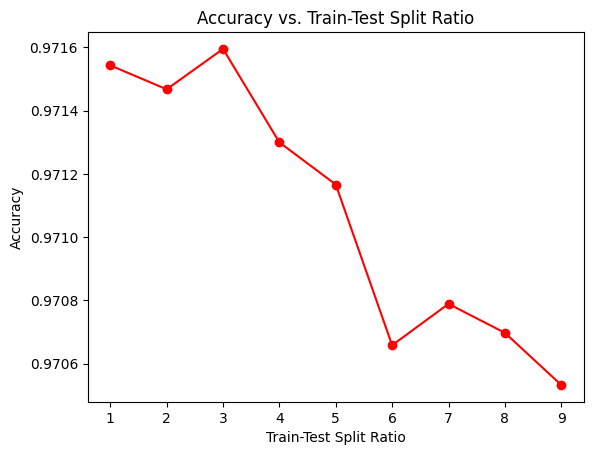

In [12]:
plt.plot(range(1, 10), s, marker='o',color = 'red')
plt.title('Accuracy vs. Train-Test Split Ratio')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.show()

In [13]:
accuracy = evaluator.evaluate(predictions)
tp = predictions.filter("diabetes = 1 AND prediction = 1").count()
fp = predictions.filter("diabetes = 0 AND prediction = 1").count()
tn = predictions.filter("diabetes = 0 AND prediction = 0").count()
fn = predictions.filter("diabetes = 1 AND prediction = 0").count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")



Accuracy: 0.9705324143442213
Precision: 1.0
Recall: 0.6549707602339181
F1 Score: 0.7915194346289752


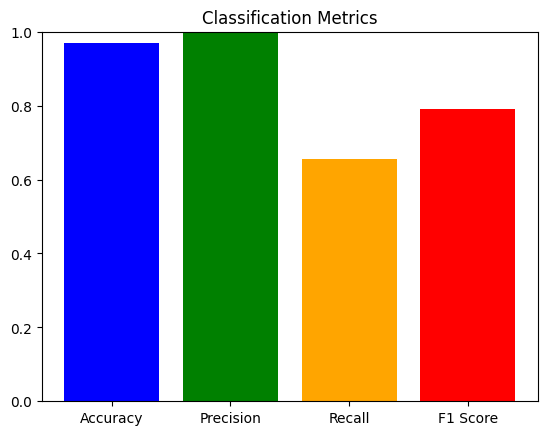

In [20]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.show()

In [16]:
prediction_and_label = predictions.select("prediction", target_col).rdd.map(lambda row: (float(row.prediction), float(row[target_col])))

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


C:\Users\blruc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[9156.    0.]
 [ 295.  560.]]


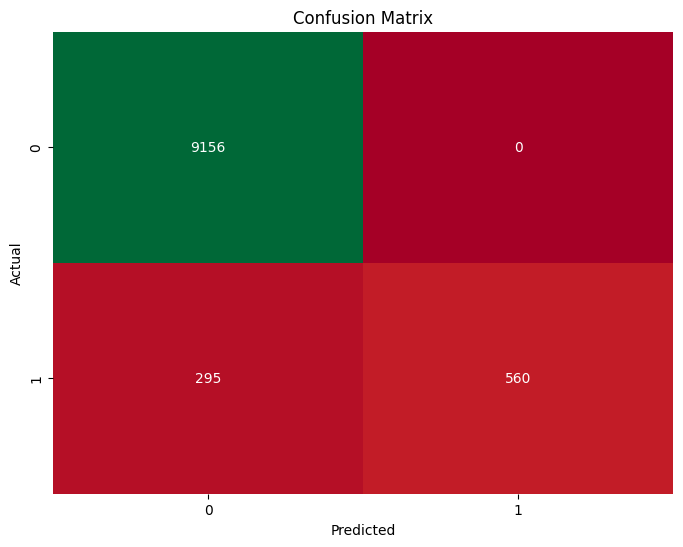

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap=sns.color_palette("RdYlGn", as_cmap=True), cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
predictions = model.transform(test_data)
predictions.show(10)

+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+----------------+--------------------+----------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|   rawPrediction|         probability|prediction|
+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+----------------+--------------------+----------+
|0.08|           0|            0|11.88|        5.7|                 80|       0|[0.08,0.0,0.0,11....|[82344.0,2518.0]|[0.97032829770686...|       0.0|
|0.08|           0|            0|12.29|        5.8|                140|       0|[0.08,0.0,0.0,12....|[82344.0,2518.0]|[0.97032829770686...|       0.0|
|0.08|           0|            0|12.89|        6.5|                145|       0|[0.08,0.0,0.0,12....|[82344.0,2518.0]|[0.97032829770686...|       0.0|
|0.08|           0|            0|14.73|        3.5|                200|       0|[0.08,0.0,0.0,

In [19]:
spark.stop()